# One Piece to the Puzzle

### My favorite part! Assessment of multiple models

http://freerangestats.info/blog/2016/12/07/arima-prediction-intervals

For Linear Regression
https://machinelearningmastery.com/prediction-intervals-for-machine-learning/



In [1]:
import pandas as pd
from matplotlib import pyplot as plt

import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn import linear_model

logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

import os
from sklearn.ensemble import GradientBoostingRegressor
rcParams['figure.figsize'] = 9, 6
import ast




C:\Users\ckato\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [4]:
#print("Current Working Directory " , os.getcwd())
#os.chdir('forecasting')
#print("Current Working Directory " , os.getcwd())

# Read data

def read_LME():


    LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
    LME_futures = LME_futures.iloc[3:, 1:]
    LME_futures.columns = ['Date', 'Cash Price ($/MT)', 'Inventory (MT)']
    LME_futures.index = LME_futures['Date']
    '''For now only select years since 2005'''
    LME_futures = LME_futures[LME_futures.index.year>=2005]

    LME_futures = LME_futures.iloc[:, 1:]

    LME = LME_futures.iloc[:, 0]
    LME = LME.astype(float)
    LME = LME.resample('B').mean()
    LME = LME.squeeze()
    return LME




### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [5]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled.index = series.index
    return unscaled


    

In [9]:
LME = read_LME()    
LME_shifted = LME.shift(-261).dropna()

# Rolling Average window setting for preprocess function above
# 5 business days * 4 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)
df = pd.DataFrame(list(zip(list(LME_stationary.index), list(LME_stationary))), columns = ['ds', 'lag0'])
df.head()

# How many lag business days to shift per lag
lag_length = 10

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

'''
df['lag11'] = df.lag0.shift(periods=11*lag_length)
df['lag12'] = df.lag0.shift(periods=13*lag_length)
df['lag13'] = df.lag0.shift(periods=15*lag_length)
df['lag14'] = df.lag0.shift(periods=17*lag_length)
df['lag15'] = df.lag0.shift(periods=19*lag_length)
df['lag16'] = df.lag0.shift(periods=21*lag_length)
df['lag17'] = df.lag0.shift(periods=23*lag_length)
'''

df.index = df['ds']
df = df.iloc[:, 1:]


df['y'] = df['lag0'].shift(-261)

#df = df.dropna(subset=['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17'])
df = df.dropna()

df.head()

X = df[['lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10' ]]
y= df['y']

X_test = X.loc['2017-12-7':,:]
y_test = y['2017-12-7':]

X_train = X.loc[:'2017-12-7', :]
y_train = y[:'2017-12-7']

train_tail = LME_shifted.loc[y_train.index[-window_setting:]]


In [10]:
df.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,y
ds,,,,,,,,,,,,
2005-06-20,-297.50,105.75,-38.75,1006.15,199.00,118.85,-180.90,132.85,1102.30,619.90,-12.25,-1325.50
2005-06-21,-740.25,-615.50,123.00,1473.65,23.50,-542.65,-388.90,259.85,429.40,1019.25,3.25,-211.00
2005-06-22,-1031.00,-765.25,237.25,1238.15,-75.00,-828.15,-204.65,259.50,195.50,734.95,29.95,-633.50
2005-06-23,-1667.25,-446.25,234.50,1458.65,120.00,-529.40,56.85,51.00,827.35,566.60,203.50,-813.75
2005-06-24,-1890.75,-533.50,-6.00,1015.25,474.25,-85.50,-251.40,514.90,764.10,905.85,-88.75,98.75


### New



In [11]:
def minimum_mae(cv_results):
    
    key_min = min(cv_results.keys(), key=(lambda k: cv_results[k]))
    min_test_mae = cv_results[key_min]
    min_parameters = key_min

    print()
    print('MAE Results by Parameter Setting:')
    for key, value in cv_results.items():
        print(key, value)
        
    print()
    print('Minimum Test MAE: ', min_test_mae)
    print('Best Parameters: ', min_parameters)

    return min_test_mae, min_parameters

def fit_predict(model, X_train, X_test, y_train, y_test, train_tail):
    '''Takes model object and 
    1. fits model on training data
    2. '''
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index
    unscaled = unscale(y_pred, train_tail, window_setting)
    original_y = unscale(y_test, train_tail, window_setting)
    return unscaled, original_y


def regression_plot(y_hat, y, model_name):
    plt.plot(y_hat)
    plt.plot(y)
    plt.legend(['y_hat', 'y'])
    plt.title(model_name + ' Regression Prediction Results', fontsize=15)

    plt.show()

In [34]:
from sklearn import linear_model

def run_lasso_grid(X_train, X_test, y_train, y_test, train_tail):
    '''Executes parameter tuning using grid search. 
    One final set of parameters is chosen and outputted with resulting MAE'''
    
    params1= ParameterGrid({'alpha' : [ .00001 ,.0001, .001, .01, .1, 1]
                                })
    cv_results = {}

    for params in params1:
        # Model Fitting
        regressor = linear_model.Lasso(**params, random_state=1)  
        unscaled, original_y = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        mae = metrics.mean_absolute_error(original_y, unscaled)
        cv_results[str(params)] = mae

    # To find the best/optimal parameters
    min_test_mae, min_parameters = minimum_mae(cv_results)

    model_name = str(regressor).split('(')[0]
    min_parameters = ast.literal_eval(min_parameters)
    regressor = linear_model.Lasso(**min_parameters, random_state=1)

    unscaled, original_y = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        
    regression_plot(unscaled, original_y, model_name)

    
    return min_test_mae, min_parameters, model_name

In [35]:
'''
y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index
'''

# y_pred = y_pred.reindex(X_test.index)


def run_linear_reg(X_train, X_test, y_train, y_test, train_tail):

    # Model Fitting
    regressor = LinearRegression()

    regressor.fit(X_train, y_train)
    unscaled, original_y = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
    mae = metrics.mean_absolute_error(original_y, unscaled)
    model_name = str(regressor).split('(')[0]
    print('Test MAE: ', mae)
    
    regression_plot(unscaled, original_y, model_name)

    min_test_mae = mae
    min_parameters = 'None'
    
    return min_test_mae, min_parameters, model_name

In [36]:
def run_adaboost_grid(X_train, X_test, y_train, y_test, train_tail):
    '''Executes parameter tuning using grid search. 
    One final set of parameters is chosen and outputted with resulting MAE'''
    
    params1= ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250],
                            'learning_rate': [ .1, .01, .001, .0001]})

    cv_results = {}

    for params in params1:
        # Model Fitting
        regressor = AdaBoostRegressor(**params, random_state=1)
        regressor.fit(X_train, y_train)
        unscaled, original_y = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)

        mae = metrics.mean_absolute_error(original_y, unscaled)
        cv_results[str(params)] = mae

    # To find the best/optimal parameters
    min_test_mae, min_parameters = minimum_mae(cv_results)

    model_name = str(regressor).split('(')[0]

    '''Rebuild Best Model with Optimal Parameters'''
    min_parameters = ast.literal_eval(min_parameters)
    regressor = AdaBoostRegressor(**min_parameters, random_state=1)
    
    unscaled, original_y = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
    regression_plot(unscaled, original_y, model_name)
    
    return min_test_mae, min_parameters, model_name

In [44]:


def run_knn(X_train, X_test, y_train, y_test, train_tail):
    
    params1= range(1,67,3)
    
    cv_results = {}

    for K in params1:
        # Model Fitting
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
        unscaled, original_y = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        mae = metrics.mean_absolute_error(original_y, unscaled)
        cv_results[str(K)] = mae

    # To find the best/optimal parameters
    min_test_mae, min_parameters = minimum_mae(cv_results)

    model_name = str(regressor).split('(')[0]
    min_parameters = ast.literal_eval(min_parameters)
    regressor = regressor = neighbors.KNeighborsRegressor(n_neighbors=min_parameters)

    unscaled, original_y = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        
    regression_plot(unscaled, original_y, model_name)

    
    return min_test_mae, min_parameters, model_name

In [50]:


def run_polynomial(X_train, X_test, y_train, y_test, train_tail):
    '''Polynomial regression needs to be fitted separately, since it uses a linear regression base'''
    params1= range(1,4)

    cv_results = {}

    for deg in params1:
        # Model Fitting
        polynomial_features= PolynomialFeatures(degree=deg)

        X_poly = polynomial_features.fit_transform(X_train)

        regressor = LinearRegression()
        regressor.fit(X_poly, y_train)

        X_poly_test = polynomial_features.fit_transform(X_test)
        y_poly_pred = regressor.predict(X_poly_test)
        y_poly_pred = pd.Series(y_poly_pred)
        y_poly_pred.index = y_test.index
        
        unscaled, original_y = unscale(y_poly_pred, train_tail, window_setting), unscale(y_test, train_tail, window_setting)
        
        mae = metrics.mean_absolute_error(original_y, unscaled)
        cv_results[str(deg)] = mae

    # To find the best/optimal parameters
    min_test_mae, min_parameters = minimum_mae(cv_results)

    model_name = "Polynomial Regression"
    min_parameters = ast.literal_eval(min_parameters)
    
    polynomial_features= PolynomialFeatures(degree=min_parameters)

    X_poly = polynomial_features.fit_transform(X_train)

    regressor = LinearRegression()
    regressor.fit(X_poly, y_train)

    X_poly_test = polynomial_features.fit_transform(X_test)
    y_poly_pred = regressor.predict(X_poly_test)
    y_poly_pred = pd.Series(y_poly_pred)
    y_poly_pred.index = y_test.index

    unscaled, original_y = unscale(y_poly_pred, train_tail, window_setting), unscale(y_test, train_tail, window_setting)
            
    regression_plot(unscaled, original_y, model_name)

    
    return min_test_mae, min_parameters, model_name

In [52]:

def run_rf_grid(X_train, X_test, y_train, y_test, train_tail):
    '''Random Forest Regression'''
    
    params1=  ParameterGrid({'n_estimators' : [50, 100, 150, 200, 250, 300],
                            'min_samples_leaf': [ .15,  .25, .35, .45]})
    cv_results = {}

    for params in params1:
        # Model Fitting
        regressor = RandomForestRegressor(**params, random_state=1) 
        unscaled, original_y = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        mae = metrics.mean_absolute_error(original_y, unscaled)
        cv_results[str(params)] = mae

    # To find the best/optimal parameters
    min_test_mae, min_parameters = minimum_mae(cv_results)

    model_name = str(regressor).split('(')[0]
    min_parameters = ast.literal_eval(min_parameters)
    regressor = RandomForestRegressor(**params, random_state=1)

    unscaled, original_y = fit_predict(regressor, X_train, X_test, y_train, y_test, train_tail)
        
    regression_plot(unscaled, original_y, model_name)

    
    return min_test_mae, min_parameters, model_name


MAE Results by Parameter Setting:
{'min_samples_leaf': 0.15, 'n_estimators': 50} 3073.1404775027895
{'min_samples_leaf': 0.15, 'n_estimators': 100} 3035.0436505874272
{'min_samples_leaf': 0.15, 'n_estimators': 150} 3040.4736132122944
{'min_samples_leaf': 0.15, 'n_estimators': 200} 3053.897704594556
{'min_samples_leaf': 0.15, 'n_estimators': 250} 3047.4011481050243
{'min_samples_leaf': 0.15, 'n_estimators': 300} 3048.194812797946
{'min_samples_leaf': 0.25, 'n_estimators': 50} 3316.280957145679
{'min_samples_leaf': 0.25, 'n_estimators': 100} 3325.349408596715
{'min_samples_leaf': 0.25, 'n_estimators': 150} 3323.689164957328
{'min_samples_leaf': 0.25, 'n_estimators': 200} 3311.760686072431
{'min_samples_leaf': 0.25, 'n_estimators': 250} 3312.8161421768837
{'min_samples_leaf': 0.25, 'n_estimators': 300} 3299.7084126870923
{'min_samples_leaf': 0.35, 'n_estimators': 50} 3177.9477483030773
{'min_samples_leaf': 0.35, 'n_estimators': 100} 3171.5440304946655
{'min_samples_leaf': 0.35, 'n_estima

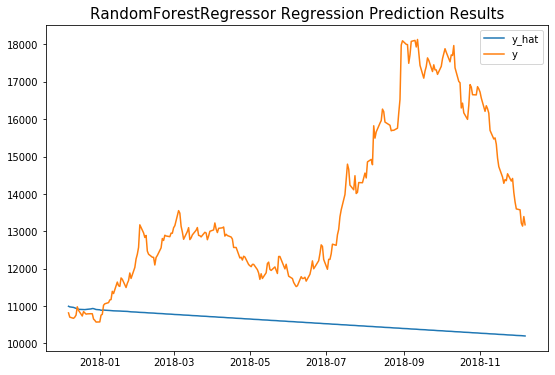

(3035.0436505874272,
 {'min_samples_leaf': 0.15, 'n_estimators': 100},
 'RandomForestRegressor')

In [53]:
train_tail = LME_shifted.loc[y_train.index[-window_setting:]]


#run_linear_reg(X_train, X_test, y_train, y_test)
#run_adaboost_grid(X_train, X_test, y_train, y_test)
#run_lasso_grid(X_train, X_test, y_train, y_test, train_tail)
#run_knn(X_train, X_test, y_train, y_test, train_tail)
#run_polynomial(X_train, X_test, y_train, y_test, train_tail)

run_rf_grid(X_train, X_test, y_train, y_test, train_tail)

Test MAE:  3590.4520704062897


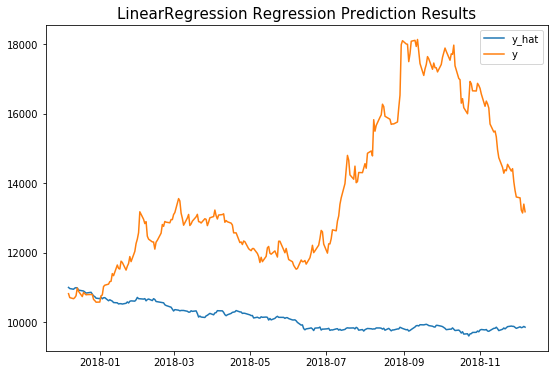


MAE Results by Parameter Setting:
{'learning_rate': 0.1, 'n_estimators': 50} 1154.9549740973375
{'learning_rate': 0.1, 'n_estimators': 100} 3264.592839002543
{'learning_rate': 0.1, 'n_estimators': 150} 5437.2778271506295
{'learning_rate': 0.1, 'n_estimators': 200} 7256.832242487544
{'learning_rate': 0.1, 'n_estimators': 250} 8691.71565764538
{'learning_rate': 0.01, 'n_estimators': 50} 1378.9778273309953
{'learning_rate': 0.01, 'n_estimators': 100} 1232.0388419712463
{'learning_rate': 0.01, 'n_estimators': 150} 1140.5304973261782
{'learning_rate': 0.01, 'n_estimators': 200} 1109.4235255096387
{'learning_rate': 0.01, 'n_estimators': 250} 1106.0989540513565
{'learning_rate': 0.001, 'n_estimators': 50} 1488.4625905403627
{'learning_rate': 0.001, 'n_estimators': 100} 1429.148462974269
{'learning_rate': 0.001, 'n_estimators': 150} 1407.0904836214183
{'learning_rate': 0.001, 'n_estimators': 200} 1427.210191827094
{'learning_rate': 0.001, 'n_estimators': 250} 1412.9964248259034
{'learning_rat

In [ ]:
train_tail = LME_shifted.loc[y_train.index[-window_setting:]]

functions = [run_linear_reg, 
             run_adaboost_grid,
             run_knn]

for i in range(3):
    functions[i](X_train, X_test, y_train, y_test, train_tail)

#run_linear_reg(X_train, X_test, y_train, y_test)
#run_adaboost_grid(X_train, X_test, y_train, y_test)
#run_lasso_grid(X_train, X_test, y_train, y_test, train_tail)
#run_knn(X_train, X_test, y_train, y_test, train_tail)
#run_polynomial(X_train, X_test, y_train, y_test, train_tail)

#min_test_mae, min_parameters, model_name = run_rf_grid(X_train, X_test, y_train, y_test, train_tail)

# Other Kinds of Regression

Grid Search for RIDGE Regression

# MAIN GOOD ONES
Knn K=6 
2 week lags at 3 week rolling average windows 

Knn K=7
4 week lags at 4 week rolling average windows 

Polynomial 
4 month lags 8 week rolling average windows


ds
2017-10-16    12516.5
2017-10-17    12298.5
2017-10-18    12276.0
2017-10-19    12372.0
2017-10-20    12447.5
dtype: float64
ds
2000-11-06    4521.0
2000-11-07    4532.0
2000-11-08    4614.0
2000-11-09    4891.0
2000-11-10    5499.5
dtype: float64


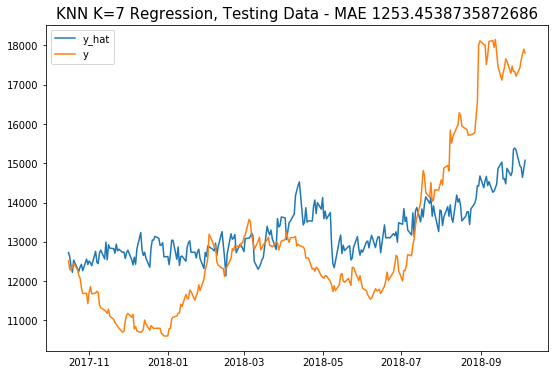

Mean Absolute Error: 1253.4538735872686
Mean Squared Error: 2347471.5514717815
Root Mean Squared Error: 1532.1460607500126


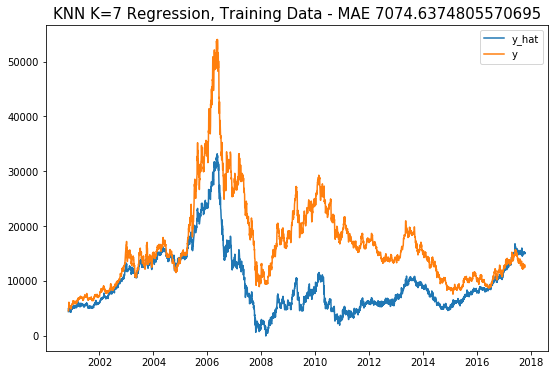

Mean Absolute Error: 7074.6374805570695
Mean Squared Error: 84440250.35487752
Root Mean Squared Error: 9189.137628465334


In [183]:
K = 7
regressor = neighbors.KNeighborsRegressor(n_neighbors=K)
regressor.fit(X_train, y_train)

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K) +' Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('KNN K=' +str(K)+' Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/KNN_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


ds
2017-10-16    12516.5
2017-10-17    12298.5
2017-10-18    12276.0
2017-10-19    12372.0
2017-10-20    12447.5
dtype: float64
ds
2000-11-06    4521.0
2000-11-07    4532.0
2000-11-08    4614.0
2000-11-09    4891.0
2000-11-10    5499.5
dtype: float64


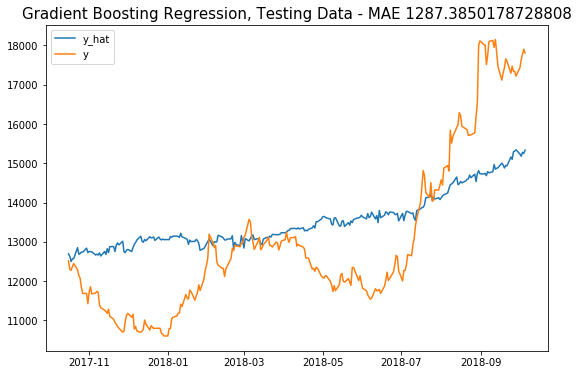

Mean Absolute Error: 1287.3850178728808
Mean Squared Error: 2380259.539884321
Root Mean Squared Error: 1542.8089771207326


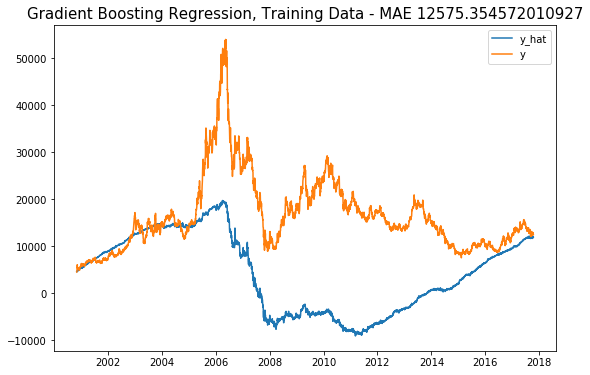

Mean Absolute Error: 12575.354572010927
Mean Squared Error: 264481461.72992408
Root Mean Squared Error: 16262.886020935031


In [33]:
regressor=mid_model

y_pred_train  = regressor.predict(X_train)
y_pred_train = pd.Series(y_pred_train)
y_pred_train.index = y_train.index

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

LME_shifted = LME.shift(-261).dropna()

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Gradient Boosting Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/gradient_boost_mid_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Gradient Boosting Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/gradient_boost_mid_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))

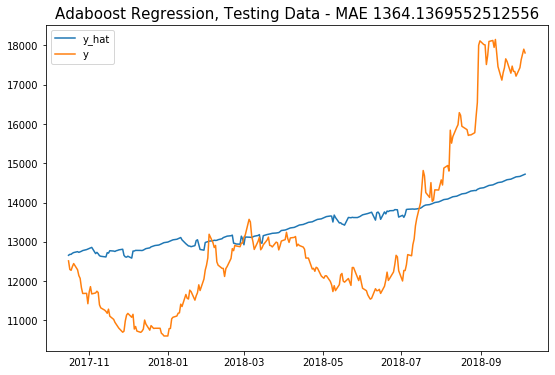

Mean Absolute Error: 1364.1369552512556
Mean Squared Error: 2668909.322509097
Root Mean Squared Error: 1633.6796878547204


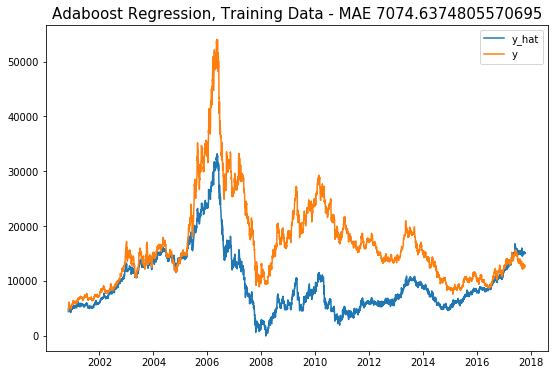

Mean Absolute Error: 7074.6374805570695
Mean Squared Error: 84440250.35487752
Root Mean Squared Error: 9189.137628465334


In [184]:
regressor = AdaBoostRegressor(learning_rate=.0001, n_estimators=50, random_state=1)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)
y_pred = pd.Series(y_pred)
y_pred.index = y_test.index

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Adaboost Regression, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/adaboost_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))


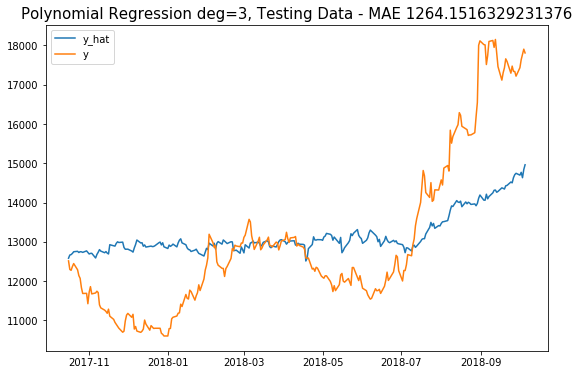

Mean Absolute Error: 1264.1516329231376
Mean Squared Error: 2543648.9721006383
Root Mean Squared Error: 1594.882118559437


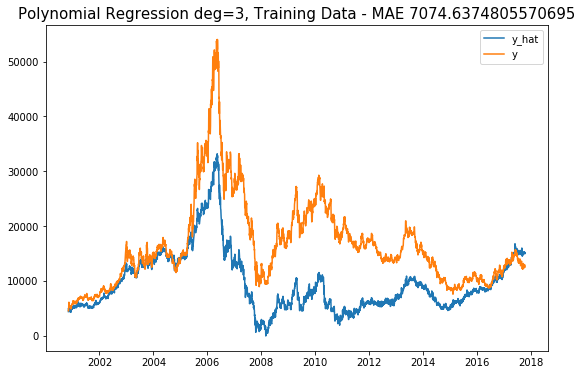

Mean Absolute Error: 7074.6374805570695
Mean Squared Error: 84440250.35487752
Root Mean Squared Error: 9189.137628465334


In [185]:
polynomial_features= PolynomialFeatures(degree=3)

X_poly = polynomial_features.fit_transform(X_train)

regressor = LinearRegression()
regressor.fit(X_poly, y_train)

X_poly_test = polynomial_features.fit_transform(X_test)
y_poly_pred = regressor.predict(X_poly_test)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_test.index

y_pred = y_poly_pred


X_poly_train = polynomial_features.fit_transform(X_train)
y_poly_pred = regressor.predict(X_poly_train)
y_poly_pred = pd.Series(y_poly_pred)
y_poly_pred.index = y_train.index

y_pred_train_unscaled = y_poly_pred


##############

original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
unscaled = unscale(y_pred, original_tail, window_setting)
unscaled.index = y_test.index


original_y = unscale(y_test, original_tail, window_setting)
original_y.index = y_test.index
#print(original_y.head())

###############

original_tail_train = LME_shifted.loc[y_train.index[:window_setting]]

original_y_train = unscale(y_train.iloc[window_setting:], original_tail_train, window_setting)
original_y_train.index = y_train[window_setting:].index

y_pred_train_unscaled = unscale(y_pred_train.iloc[window_setting:], original_tail_train, window_setting)
y_pred_train_unscaled.index = y_train[window_setting:].index

#print(original_y_train.head())

###########

plt.plot(unscaled)
plt.plot(original_y)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Testing Data - MAE ' + str(metrics.mean_absolute_error(original_y, unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_test.png'
#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y, unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y, unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y, unscaled)))

results = pd.DataFrame({'y_test': original_y, 'y_pred_unscaled': unscaled})
results['error'] = results['y_test'] - results['y_pred_unscaled']



plt.plot(y_pred_train_unscaled)
plt.plot(original_y_train)
plt.legend(['y_hat', 'y'])
plt.title('Polynomial Regression deg=3, Training Data - MAE '+ str(metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled)), fontsize=15)
filename = 'results/polynomial_' + 'window_'+ str(window_setting) + 'lag_'+str(lag_length)+'_train.png'

#plt.savefig(filename)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(original_y_train, y_pred_train_unscaled))  
print('Mean Squared Error:', metrics.mean_squared_error(original_y_train, y_pred_train_unscaled))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(original_y_train, y_pred_train_unscaled)))





In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725
